In [1]:
from datetime import datetime
# 打印当前时间，按照年-月-日 小时:分钟:秒的格式
print("Start time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# 记录开始时间
from time import time
start = time()

Start time: 2024-12-10 18:11:38


# golden数据单独训练探针

In [2]:
# 全局变量
# 图片保存文件夹路径
FIG_DIR = "output/data/figures/golden"
# 采样类型
SAMPLE_TYPE = "golden"
# 模型层数
NUMBER_OF_LAYERS = 28 # Qwen2.5-7B共有28层

In [3]:
%load_ext autoreload
%autoreload 2

import json
import warnings
import os
import pickle
from tqdm import tqdm
import torch
from collections import defaultdict, Counter
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
rng = np.random.default_rng(42)


def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

In [4]:
# Create Dataset class for easier attribute keeping
class Dataset:
    name = ''
    tbg_dataset = None
    slt_dataset = None
    entropy = None
    accuracies = None

    sample_type = ''
    model_name = ''
    dataset_name = ''
    split = ''
    def __init__(self, name, tbg_dataset, slt_dataset, entropy, accuracies, sample_type, model_name, dataset_name, split):
        self.name = name
        self.tbg_dataset = tbg_dataset
        self.slt_dataset = slt_dataset
        self.entropy = entropy
        self.accuracies = accuracies
        self.sample_type = sample_type
        self.model_name = model_name
        self.dataset_name = dataset_name
        self.split = split

all_data = load_pickle_file("output/data/all_data.pkl")


model_name = "Qwen/Qwen2.5-7B-Instruct"
dataset_names = ["squad", "triviaqa"]
split = "train"
sample_type = SAMPLE_TYPE

Ds = []
for dataset_name in dataset_names:
    ds = all_data[model_name][dataset_name][split][sample_type]
    Ds.append(ds)

for i, D in enumerate(Ds):
    # OOD-related
    D.other_ids = [j for j in range(len(Ds)) if j != i]
    D.other_names = [Ds[j].name for j in D.other_ids]

# 打印数据集信息
for ds in Ds:
    print(f"{ds.model_name} {ds.dataset_name} {ds.split}: {len(ds.accuracies)}")

Qwen/Qwen2.5-7B-Instruct squad train: 2000
Qwen/Qwen2.5-7B-Instruct triviaqa train: 2000


### Helper Methods

In [5]:
# Create train/val/test splits
def create_Xs_and_ys(datasets, scores, val_test_splits=[0.2, 0.1], test_only=False, no_val=False):
    # Data splitting for sklearn linear models
    X = np.array(datasets)
    y = np.array(scores)

    if test_only:
        X_tests, y_tests = [], []
        
        for i in range(X.shape[0]):
            X_tests.append(X[i])
            y_tests.append(y)
        return (None, None, X_tests, None, None, y_tests)
    
    valid_size = val_test_splits[0]
    test_size = val_test_splits[1]

    X_trains, X_vals, X_tests, y_trains, y_vals, y_tests = [], [], [], [], [], []

    for i in range(X.shape[0]):
        # Split data into train, validation, and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X[i], y, test_size=test_size, random_state=42)
        X_tests.append(X_test)
        y_tests.append(y_test)
        if no_val:
            X_trains.append(X_train_val)
            y_trains.append(y_train_val)
            continue
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=valid_size, random_state=42) 
        X_trains.append(X_train)
        y_trains.append(y_train)
        X_vals.append(X_val)
        y_vals.append(y_val)

    return X_trains, X_vals, X_tests, y_trains, y_vals, y_tests


In [6]:
# Bootstrapping methods from ../semantic_entropy/uncertainty/utils/eval_utils.py
def bootstrap_func(y_true, y_score, func):
    y_tuple = (y_true, y_score)
    
    metric_i = func(*y_tuple)
    metric_dict = {}
    metric_dict['mean'] = metric_i
    metric_dict['bootstrap'] = compatible_bootstrap(
        func, rng)(*y_tuple)  # a bit slow to run

    return metric_dict

def bootstrap(function, rng, n_resamples=1000):
    def inner(data):
        bs = scipy.stats.bootstrap(
            (data, ), function, n_resamples=n_resamples, confidence_level=0.9,
            random_state=rng)
        return {
            'std_err': bs.standard_error,
            'low': bs.confidence_interval.low,
            'high': bs.confidence_interval.high
        }
    return inner

def auroc(y_true, y_score):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    del thresholds
    return metrics.auc(fpr, tpr)

def compatible_bootstrap(func, rng):
    def helper(y_true_y_score):
        # this function is called in the bootstrap
        y_true = np.array([i['y_true'] for i in y_true_y_score])
        y_score = np.array([i['y_score'] for i in y_true_y_score])
        out = func(y_true, y_score)
        return out

    def wrap_inputs(y_true, y_score):
        return [{'y_true': i, 'y_score': j} for i, j in zip(y_true, y_score)]

    def converted_func(y_true, y_score):
        y_true_y_score = wrap_inputs(y_true, y_score)
        return bootstrap(helper, rng=rng)(y_true_y_score)
    return converted_func

In [7]:
# Train and evaluation function.
def sklearn_train_and_evaluate(model, X_train, y_train, X_valid, y_valid, silent=False):
    model.fit(X_train, y_train)
    
    # Calculate training loss and score
    train_probs = model.predict_proba(X_train)
    train_loss = log_loss(y_train, train_probs)

    # Calculate validation loss
    valid_preds = model.predict(X_valid)
    valid_probs = model.predict_proba(X_valid)
    valid_loss = log_loss(y_valid, valid_probs)
    val_accuracy = np.mean((valid_preds == y_valid).astype(int))
    auroc_score = roc_auc_score(y_valid, valid_probs[:,1])
    if not silent:
        print(f"Validation Accuracy: {val_accuracy:.4f}, AUROC: {auroc_score:.4f}")
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

def sklearn_evaluate_on_test(model, X_test, y_test, silent=False, bootstrap=True):
    test_preds = model.predict(X_test)
    test_probs = model.predict_proba(X_test)
    test_loss = log_loss(y_test, test_probs)
    test_accuracy = np.mean((test_preds == y_test).astype(int))
    
    if bootstrap:
        auroc_score = bootstrap_func(y_test, test_probs[:,1], auroc)
        auroc_score_scalar = auroc_score['mean']
    else:
        auroc_score = auroc_score_scalar = roc_auc_score(y_test, test_probs[:, 1])
    
    if not silent:
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, AUROC: {auroc_score_scalar:.4f}")
    
    return test_loss, test_accuracy, auroc_score

def train_single_metric(D, token_type='tbg', metric='b_entropy'):
    """train and test on single metric (e.g. SE, Acc) on single dataset"""
    var_name = token_type[0] + metric[0] 
    # named as [te, se. ta, sa] for easy identification; t for tbg, s for slt (token positions)
    # e for entropy and a for accuracy (or model faithfulness)
    X_trains, X_vals, X_tests, y_trains, y_vals, y_tests = create_Xs_and_ys(
        getattr(D, f'{token_type}_dataset'), getattr(D, metric)
    )

    accs = []
    aucs = []
    models = []
    
    for i, (X_train, X_val, X_test, y_train, y_val, y_test) in enumerate(zip(X_trains, X_vals, X_tests, y_trains, y_vals, y_tests)):
        print(f"Training on {D.name}-{token_type.upper()}-{metric.upper()} {i+1}/{len(X_trains)}")
        model = LogisticRegression()
        sklearn_train_and_evaluate(model, X_train, y_train, X_val, y_val)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test, y_test)
        accs.append(test_acc)
        aucs.append(test_auc)
        models.append(model)

    setattr(D, f'{var_name}_accs', accs)
    setattr(D, f'{var_name}_aucs', aucs)
    setattr(D, f'{var_name}_models', models)

# simple get-around for unpacking bootstrapping dicts
auc = lambda aucs : [ac['mean'] for ac in aucs] 
idf = lambda x : x  # identical function

In [8]:
# Plotting methods
def plot_metrics_ax(ax, test_metrics_list, model_names, title="", prep_func=auc, 
                    use_logarithm=False, preset_layer_indices=None, legend_outside=False):  # some simple gadgets
    """plot metrics along certain axis in a multi-axis plot (plt.subplots)"""
    if len(test_metrics_list) != len(model_names):
        raise ValueError("The length of test_metrics_list and model_names must be the same.")
    
    for test_metrics, model_name in zip(test_metrics_list, model_names):
        test_metrics = torch.tensor(prep_func(test_metrics), dtype=torch.float32)
        if use_logarithm:
            test_metrics = torch.log(test_metrics + 1e-6)
        if preset_layer_indices is not None:
            layer_indices = preset_layer_indices
        else:
            layer_indices = torch.arange(len(test_metrics)) + 1  # +1 if layer indexing starts at 1
        
        ax.plot(layer_indices, test_metrics, marker='o', linestyle='-', linewidth=2, markersize=5, label=model_name)
    
    ax.set_title(f'{title}', fontsize=14)
    ax.set_xlabel('Layer', fontsize=12)
    ax.set_ylabel(f'Test AUROC scores', fontsize=12)
    
    tick_interval = 5  # Change this value to display more or fewer ticks
    ax.set_xticks(layer_indices[::tick_interval].tolist())
    ax.set_xticklabels(layer_indices[::tick_interval].tolist())
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    if legend_outside:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    else:
        ax.legend(fontsize=12)

def save_fig(name):
    """save figure with timestamps"""
    dir_path = os.path.expanduser(FIG_DIR)
    os.makedirs(dir_path, exist_ok=True)
    full_path = os.path.join(dir_path, f'{name}.pdf')
    plt.savefig(full_path, format='pdf', dpi=300)

In [9]:
# Best split for SE binarization.
def best_split(entropy: torch.Tensor, label="Dx"):
    """
    Identify best split for minimizing reconstruction error via low and high SE mean estimates,
    as discussed in Section 4. Binarization of paper (ArXiv: 2406.15927)
    """
    ents = entropy.numpy()
    splits = np.linspace(1e-10, ents.max(), 100)
    split_mses = []
    for split in splits:
        low_idxs, high_idxs = ents < split, ents >= split
    
        low_mean = np.mean(ents[low_idxs])
        high_mean = np.mean(ents[high_idxs])
    
        mse = np.sum((ents[low_idxs] - low_mean)**2) + np.sum((ents[high_idxs] - high_mean)**2)
        mse = np.sum(mse)
    
        split_mses.append(mse)
    
    split_mses = np.array(split_mses)
    
    plt.plot(splits, split_mses, label=label)
    return splits[np.argmin(split_mses)]

def binarize_entropy(entropy, thres=0.0):  # 0.0 means even splits for normalized entropy scores
    """Binarize entropy scores into 0s and 1s"""
    binary_entropy = torch.full_like(entropy, -1, dtype=torch.float)
    binary_entropy[entropy < thres] = 0
    binary_entropy[entropy > thres] = 1

    return binary_entropy

### 二值化语义熵

Dummy accuracy for squad-golden: 0.9185
Dummy accuracy for triviaqa-golden: 0.7700


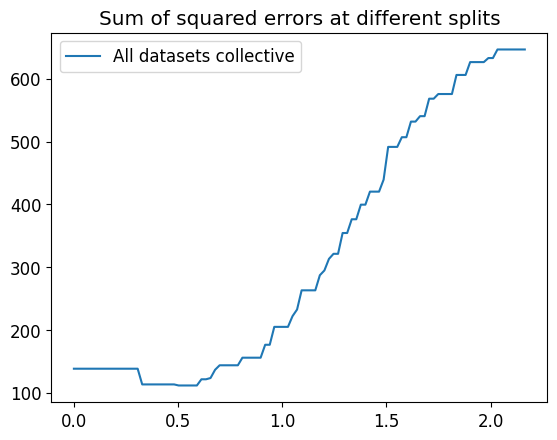

In [10]:
# Best universal split across datasets
split_method = 'best-universal-split'
all_entropy = torch.cat([D.entropy for D in Ds], dim=0)
split = best_split(all_entropy, "All datasets collective")
plt.legend()
plt.title('Sum of squared errors at different splits')
for D in Ds:
    D.b_entropy = binarize_entropy(D.entropy, split)
    print(f"Dummy accuracy for {D.name}: {max(torch.mean(D.b_entropy).item(), 1-torch.mean(D.b_entropy).item()):.4f}")

### Train linear probes to predict Binarized SE

In [11]:
for D in Ds:
    train_single_metric(D, 'tbg', 'b_entropy')
    train_single_metric(D, 'slt', 'b_entropy')

Training on squad-golden-TBG-B_ENTROPY 1/29
Validation Accuracy: 0.9083, AUROC: 0.5000
Training Loss: 0.2868, Validation Loss: 0.3068
Test Loss: 0.2069, Test Accuracy: 0.9500, AUROC: 0.5000
Training on squad-golden-TBG-B_ENTROPY 2/29
Validation Accuracy: 0.9083, AUROC: 0.6006
Training Loss: 0.2327, Validation Loss: 0.3071
Test Loss: 0.2048, Test Accuracy: 0.9500, AUROC: 0.6279
Training on squad-golden-TBG-B_ENTROPY 3/29
Validation Accuracy: 0.9056, AUROC: 0.5969
Training Loss: 0.2046, Validation Loss: 0.3138
Test Loss: 0.2038, Test Accuracy: 0.9450, AUROC: 0.6584
Training on squad-golden-TBG-B_ENTROPY 4/29
Validation Accuracy: 0.9056, AUROC: 0.6145
Training Loss: 0.1779, Validation Loss: 0.3154
Test Loss: 0.2260, Test Accuracy: 0.9250, AUROC: 0.6305
Training on squad-golden-TBG-B_ENTROPY 5/29
Validation Accuracy: 0.9083, AUROC: 0.6056
Training Loss: 0.1599, Validation Loss: 0.3238
Test Loss: 0.2253, Test Accuracy: 0.9400, AUROC: 0.6121
Training on squad-golden-TBG-B_ENTROPY 6/29
Valida

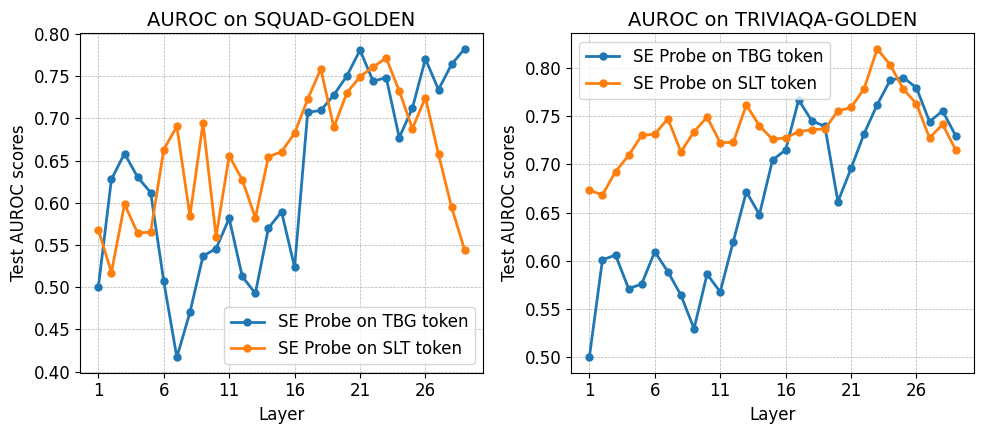

In [12]:
# plot se probe
fig, axs = plt.subplots(1, len(Ds), figsize=(5 * len(Ds), 4.5))
for i, D in enumerate(Ds):
    plot_metrics_ax(axs[i], [auc(D.tb_aucs), auc(D.sb_aucs)], ["SE Probe on TBG token", "SE Probe on SLT token"], 
                    f"AUROC on {D.name.upper()}", prep_func=idf)
plt.tight_layout()
save_fig(name="se_both_tok")
plt.show()

### Train linear probes to predict Accuracy

In [13]:
for D in Ds:
    train_single_metric(D, 'tbg', 'accuracies')
    train_single_metric(D, 'slt', 'accuracies')

Training on squad-golden-TBG-ACCURACIES 1/29
Validation Accuracy: 0.8833, AUROC: 0.5000
Training Loss: 0.3848, Validation Loss: 0.3609
Test Loss: 0.3291, Test Accuracy: 0.9000, AUROC: 0.5000
Training on squad-golden-TBG-ACCURACIES 2/29
Validation Accuracy: 0.8833, AUROC: 0.5776
Training Loss: 0.3145, Validation Loss: 0.3606
Test Loss: 0.3256, Test Accuracy: 0.8950, AUROC: 0.6211
Training on squad-golden-TBG-ACCURACIES 3/29
Validation Accuracy: 0.8778, AUROC: 0.5847
Training Loss: 0.2817, Validation Loss: 0.3673
Test Loss: 0.3360, Test Accuracy: 0.8950, AUROC: 0.5250
Training on squad-golden-TBG-ACCURACIES 4/29
Validation Accuracy: 0.8778, AUROC: 0.6464
Training Loss: 0.2466, Validation Loss: 0.3631
Test Loss: 0.3517, Test Accuracy: 0.8950, AUROC: 0.5264
Training on squad-golden-TBG-ACCURACIES 5/29
Validation Accuracy: 0.8806, AUROC: 0.6087
Training Loss: 0.2250, Validation Loss: 0.3749
Test Loss: 0.3379, Test Accuracy: 0.9050, AUROC: 0.5603
Training on squad-golden-TBG-ACCURACIES 6/29


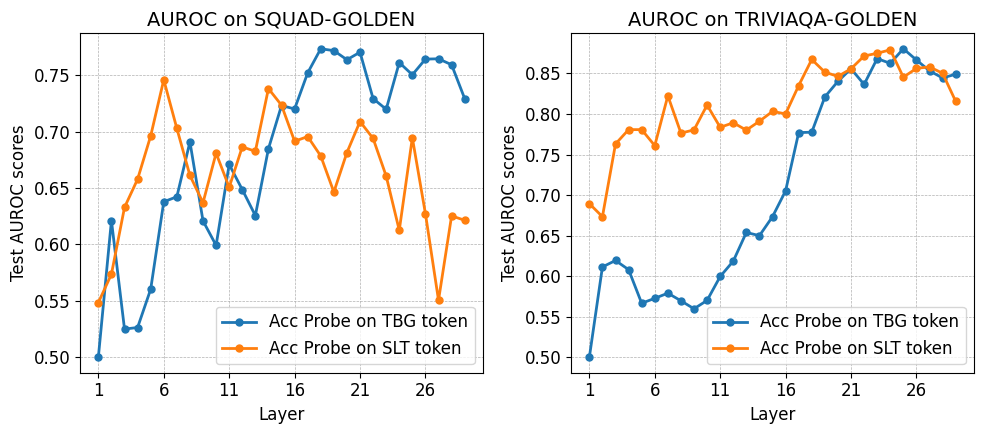

In [14]:
# plot acc probe
fig, axs = plt.subplots(1, len(Ds), figsize=(5 * len(Ds), 4.5))
for i, D in enumerate(Ds):
    plot_metrics_ax(axs[i], [auc(D.ta_aucs), auc(D.sa_aucs)], ["Acc Probe on TBG token", "Acc Probe on SLT token"], 
                    f"AUROC on {D.name.upper()}", prep_func=idf)
plt.tight_layout()
save_fig(name="acc_both_tok")
plt.show()

### Use linear probe trained on Binarized SE to predict Accuracy

We leverage trained probes on semantic entropy to predict model correctness on the same dataset.

Note that we need to predict the error rate (1 minus accuracy) using SEPs due to the nature of semantic uncertainty.

In [15]:
for D in Ds:
    r_acc = 1 - D.accuracies
    
    # TBG
    _, _, X_tests, _, _, y_tests = create_Xs_and_ys(D.tbg_dataset, r_acc) 
    tab_accs = []
    tab_aucs = []
    
    for i, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"Testing on {D.name}-TBG {i+1}/{len(X_tests)}")
        model = D.tb_models[i]
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test, y_test)
        tab_accs.append(test_acc)
        tab_aucs.append(test_auc)

    D.tab_accs = tab_accs
    D.tab_aucs = tab_aucs

    # SLT t
    _, _, X_tests, _, _, y_tests = create_Xs_and_ys(D.slt_dataset, r_acc)     
    sab_accs = []
    sab_aucs = []
    
    for i, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"Testing on {D.name}-SLT {i+1}/{len(X_tests)}")
        model = D.sb_models[i]
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test, y_test)
        sab_accs.append(test_acc)
        sab_aucs.append(test_auc)

    D.sab_accs = sab_accs
    D.sab_aucs = sab_aucs

Testing on squad-golden-TBG 1/29
Test Loss: 0.3268, Test Accuracy: 0.9000, AUROC: 0.5000
Testing on squad-golden-TBG 2/29
Test Loss: 0.3418, Test Accuracy: 0.9000, AUROC: 0.5019
Testing on squad-golden-TBG 3/29
Test Loss: 0.3483, Test Accuracy: 0.8950, AUROC: 0.5067
Testing on squad-golden-TBG 4/29
Test Loss: 0.3866, Test Accuracy: 0.8850, AUROC: 0.4767
Testing on squad-golden-TBG 5/29
Test Loss: 0.3801, Test Accuracy: 0.8900, AUROC: 0.5197
Testing on squad-golden-TBG 6/29
Test Loss: 0.3847, Test Accuracy: 0.9000, AUROC: 0.5450
Testing on squad-golden-TBG 7/29
Test Loss: 0.4448, Test Accuracy: 0.8900, AUROC: 0.5025
Testing on squad-golden-TBG 8/29
Test Loss: 0.4344, Test Accuracy: 0.8850, AUROC: 0.5158
Testing on squad-golden-TBG 9/29
Test Loss: 0.4658, Test Accuracy: 0.8850, AUROC: 0.5122
Testing on squad-golden-TBG 10/29
Test Loss: 0.5288, Test Accuracy: 0.8850, AUROC: 0.4636
Testing on squad-golden-TBG 11/29
Test Loss: 0.4776, Test Accuracy: 0.8850, AUROC: 0.5025
Testing on squad-go

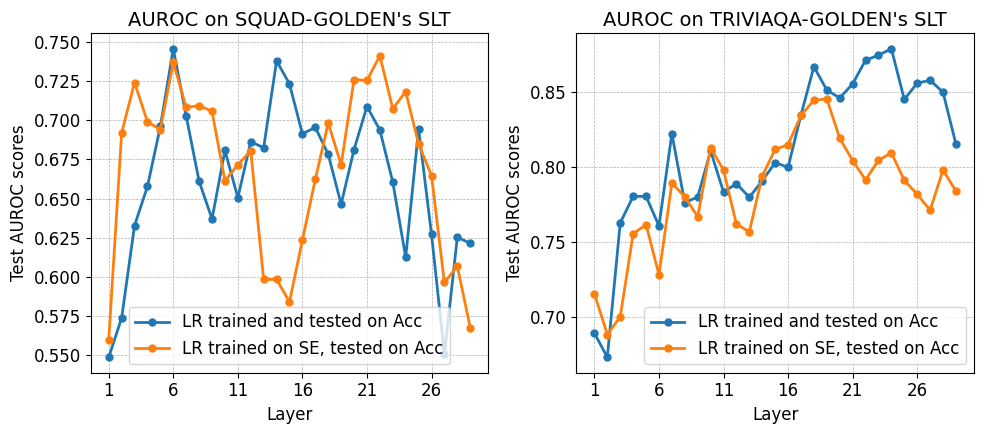

In [16]:
fig, axs = plt.subplots(1, len(Ds), figsize=(5 * len(Ds), 4.5))
for i, D in enumerate(Ds):
    plot_metrics_ax(axs[i], [D.sa_aucs, D.sab_aucs], ["LR trained and tested on Acc", "LR trained on SE, tested on Acc"], f"AUROC on {D.name.upper()}'s SLT")
plt.tight_layout()
save_fig(name="se_for_acc_slt")
plt.show()

In [17]:
# select best layer range (SLT)
def decide_layer_range(Ds, metric='entropy', limit=NUMBER_OF_LAYERS+1): # NOTE: set upperbound to be number of layers+1; e.g. for llama2-70b, it is 81.
    """
    simple logic: use ID average test AUROCs across layers to determine 
    which consecutive range of layers did the best. Do separately
    for SEP and Acc. Pr.
    """
    assert hasattr(Ds[0], 'sab_aucs') and hasattr(Ds[0], 'sa_aucs'), 'previous cells need to be run'
    if 'entropy' in metric:
        aucs = [np.array(auc(D.sab_aucs)) for D in Ds]  # test metrics for ID SEPs
    else:
        aucs = [np.array(auc(D.sa_aucs)) for D in Ds]  # test metrics for ID APs
    best_mean = -np.inf
    best_range = []
    average = lambda a,b : np.mean([np.mean(ac[a:b]) for ac in aucs])

    for i in range(limit):
        for j in range(i+1, limit):
            if j - i < 5: # must be more than 5 layers
                continue
            if average(i, j) > best_mean:
                best_mean = average(i, j)
                best_range = [i, j]

    return best_mean, best_range

emean, (e1, e2) = decide_layer_range(Ds, 'entropy')
amean, (a1, a2) = decide_layer_range(Ds, 'acc')
for D in Ds:
    D.sep_layer_range = (e1, e2)
    D.ap_layer_range = (a1, a2)
print(emean, (e1, e2), amean, (a1, a2))

0.7669123400753834 (17, 22) 0.7701132876785051 (17, 22)


In [18]:
# BOOTSTRAP: select [xx-xx] layers for bootstrapping
def concat_Xs_and_ys(layer_range, X_trains, X_vals, X_tests, y_trains, y_vals, y_tests, 
                     no_val=False, test_only=False):
    """
    Concatenate @params{layer_range} hidden state layers on train/val/test sets.

    no_val: no validation (training set only).
    test_only: no train/validation set (test set only).
    """
    if not no_val:
        X_val_cc = np.concatenate(np.array(X_vals)[layer_range], axis=1)
        y_val_cc = y_vals[layer_range[0]]
    else:
        X_val_cc = y_val_cc = None

    if not test_only:
        X_train_cc = np.concatenate(np.array(X_trains)[layer_range], axis=1)
        y_train_cc = y_trains[layer_range[0]]
    else:
        X_train_cc = y_train_cc = None
    
    X_test_cc = np.concatenate(np.array(X_tests)[layer_range], axis=1)
    y_test_cc = y_tests[layer_range[0]]
    
    return X_train_cc, X_val_cc, X_test_cc, y_train_cc, y_val_cc, y_test_cc

def train_concat_SE(D, layer_range):
    """train model on single dataset SE with concatenated layers"""
    for token_type in ['slt']: # optionally, ['slt', 'tbg']
        var_name = token_type[0]
        all_Xs_and_ys = create_Xs_and_ys(getattr(D, f'{token_type}_dataset'), D.b_entropy, test_only=True) # train on all data
        _, _, X_train_cc, _, _, y_train_cc = concat_Xs_and_ys(layer_range, *all_Xs_and_ys, no_val=True, test_only=True)
        model = LogisticRegression()
        model.fit(X_train_cc, y_train_cc)
        setattr(D, f'{var_name}_bmodel', model)

        print(f'{token_type.upper()} trained on {D.name} SE finished')
    
def train_concat_Acc(D, layer_range):
    """train model on single dataset Accuracy with concatenated layers"""
    for token_type in ['slt']: # optionally, ['slt', 'tbg']
        var_name = token_type[0]
        all_Xs_and_ys = create_Xs_and_ys(getattr(D, f'{token_type}_dataset'), D.accuracies, test_only=True) # train on all data
        _, _, X_train_cc, _, _, y_train_cc = concat_Xs_and_ys(layer_range, *all_Xs_and_ys, no_val=True, test_only=True)
        model = LogisticRegression()
        model.fit(X_train_cc, y_train_cc)
        setattr(D, f'{var_name}_amodel', model)

        print(f'{token_type.upper()} trained on {D.name} Acc finished')

def train_concat_SE_Acc_test_Acc(D, layer_ranges=[list(range(e1,e2)), list(range(a1,a2))]):
    """ID: train and test SEPs and Acc. Pr. on single dataset with concatenated layers"""
    for token_type in ['slt']: # optionally, ['slt', 'tbg']
        var_name = token_type[0]
        all_Xs_and_ys = create_Xs_and_ys(getattr(D, f'{token_type}_dataset'), D.b_entropy, no_val=True) 
        
        X_train_cc, _, _, y_train_cc, _, _ = concat_Xs_and_ys(layer_ranges[0], *all_Xs_and_ys, no_val=True)
        ab_accs = []
        ab_aucs = []
        model = LogisticRegression()
        model.fit(X_train_cc, y_train_cc)

        all_Xs_and_ys = create_Xs_and_ys(getattr(D, f'{token_type}_dataset'), D.accuracies) 
        _, _, X_test_cc, _, _, y_test_cc = concat_Xs_and_ys(layer_ranges[0], *all_Xs_and_ys) # fixed random seed ensures no data leakage
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test_cc, 1-y_test_cc) # SEP predicts error rate
        ab_accs.append(test_acc)
        ab_aucs.append(test_auc)
    
        setattr(D, f'i{var_name}b_accs', ab_accs)  # i means IDß
        setattr(D, f'i{var_name}b_aucs', ab_aucs)

        print(f'{D.name.upper()}-{token_type.upper()} trainied on SE and tested on Acc finished')
        aa_accs = []
        aa_aucs = []
        X_train_cc, _, X_test_cc, y_train_cc, _, y_test_cc = concat_Xs_and_ys(layer_ranges[1], *all_Xs_and_ys, no_val=True)
        model = LogisticRegression()
        model.fit(X_train_cc, y_train_cc)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test_cc, y_test_cc)
        aa_accs.append(test_acc)
        aa_aucs.append(test_auc)
    
        setattr(D, f'i{var_name}a_accs', aa_accs)
        setattr(D, f'i{var_name}a_aucs', aa_aucs)
        print(f'{D.name.upper()}-{token_type.upper()} trainied on Acc and tested on Acc finished')

In [19]:
# ID: train SEPs and Acc. Pr. and test them on Acc. from the same dataset
# import warnings # uncomment to disable convergence warnings
# warnings.filterwarnings('ignore')

for D in Ds:
    train_concat_SE_Acc_test_Acc(D)

Test Loss: 0.7846, Test Accuracy: 0.9000, AUROC: 0.7164
SQUAD-GOLDEN-SLT trainied on SE and tested on Acc finished
Test Loss: 0.7168, Test Accuracy: 0.8950, AUROC: 0.6889
SQUAD-GOLDEN-SLT trainied on Acc and tested on Acc finished
Test Loss: 0.9722, Test Accuracy: 0.8050, AUROC: 0.8141
TRIVIAQA-GOLDEN-SLT trainied on SE and tested on Acc finished
Test Loss: 0.6490, Test Accuracy: 0.9000, AUROC: 0.8723
TRIVIAQA-GOLDEN-SLT trainied on Acc and tested on Acc finished


In [20]:
# OOD: save model trained on individual datasets for OOD tests
for D in Ds:
    train_concat_SE(D, layer_range=list(range(e1,e2)))
    train_concat_Acc(D, layer_range=list(range(a1,a2)))
# outputs cleared for space concern

SLT trained on squad-golden SE finished
SLT trained on squad-golden Acc finished
SLT trained on triviaqa-golden SE finished
SLT trained on triviaqa-golden Acc finished


## Test probes trained with one dataset on others

We generalize SE and Acc. probes to Out-of-Distribution settings (OOD).

In [21]:
# Train on one's Acc/SE and test on others' Acc
def test_one_on_n(D, token_type='slt', 
                  layer_range1=list(range(e1,e2)), 
                  layer_range2=list(range(a1,a2))):
    var_name = token_type[0]
    other_ids = D.other_ids
    other_names = D.other_names
    metric = 'accuracies'
    a_model = getattr(D, f'{var_name}_amodel')  # Acc. Probe
    b_model = getattr(D, f'{var_name}_bmodel')  # SE Probe

    print(f"Using probes trained on datasets {D.name.upper()}'s {token_type.upper()}-SE/Acc to predict {other_names}'s {token_type.upper()}-Acc")

    oa_accs = {}
    oa_aucs = {}
    ob_accs = {}
    ob_aucs = {}
    
    for id_ in D.other_ids:
        D_id = Ds[id_]
        print(f"Testing on {D_id.name.upper()}'s {token_type.upper()}-{metric.upper()}")
        if metric == 'accuracies':
            y_metric = 1 - getattr(D_id, metric)  # error rate
        else:
            y_metric = getattr(D_id, metric)
        
        ida_accs = []
        ida_aucs = []
        idb_accs = []
        idb_aucs = []

        # create test sets with accuracy labels
        all_Xs_and_ys = create_Xs_and_ys(getattr(D_id, f'{token_type}_dataset'), y_metric, test_only=True)

        # test on Acc. Probes
        _, _, X_test_cc, _, _, y_test_cc = concat_Xs_and_ys(layer_range2, *all_Xs_and_ys, no_val=True, test_only=True)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(a_model, X_test_cc, 1-y_test_cc, bootstrap=True)
        ida_accs.append(test_acc)
        ida_aucs.append(test_auc)
        
        # test on SE Probes
        _, _, X_test_cc, _, _, y_test_cc = concat_Xs_and_ys(layer_range1, *all_Xs_and_ys, no_val=True, test_only=True)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(b_model, X_test_cc, y_test_cc, bootstrap=True)
        idb_accs.append(test_acc)
        idb_aucs.append(test_auc)

        oa_accs[D_id.name] = ida_accs
        oa_aucs[D_id.name] = ida_aucs
        ob_accs[D_id.name] = idb_accs
        ob_aucs[D_id.name] = idb_aucs

    setattr(D, 'osa_accs', oa_accs) # o means OOD
    setattr(D, 'osa_aucs', oa_aucs)
    setattr(D, 'osb_accs', ob_accs)
    setattr(D, 'osb_aucs', ob_aucs)

    print(f"Using probes trained on dataset {D.name.upper()} testing complete.")

In [22]:
for D in Ds:
    test_one_on_n(D, 'slt')

Using probes trained on datasets SQUAD-GOLDEN's SLT-SE/Acc to predict ['triviaqa-golden']'s SLT-Acc
Testing on TRIVIAQA-GOLDEN's SLT-ACCURACIES
Test Loss: 1.0636, Test Accuracy: 0.8320, AUROC: 0.7632
Test Loss: 1.1065, Test Accuracy: 0.8265, AUROC: 0.7349
Using probes trained on dataset SQUAD-GOLDEN testing complete.
Using probes trained on datasets TRIVIAQA-GOLDEN's SLT-SE/Acc to predict ['squad-golden']'s SLT-Acc
Testing on SQUAD-GOLDEN's SLT-ACCURACIES
Test Loss: 1.0064, Test Accuracy: 0.8000, AUROC: 0.6443
Test Loss: 1.1922, Test Accuracy: 0.8235, AUROC: 0.6433
Using probes trained on dataset TRIVIAQA-GOLDEN testing complete.


In [23]:
# compute the OOD average: mean([train on B-> test on A, train on C -> test on A, train on D-> test on A])
b_performances = defaultdict(list)
a_performances = defaultdict(list)
win_rate = []
for D in Ds:
    for name in D.other_names:
        b_performances[name].append(auc(D.osb_aucs[name]))
        a_performances[name].append(auc(D.osa_aucs[name]))
        if auc(D.osb_aucs[name]) > auc(D.osa_aucs[name]):
            win_rate.append(1)
        else:
            win_rate.append(0)

print(f"winning rate: {np.mean(win_rate)*100:.2f}%")

for D in Ds:
    D.sep_ood_avg = np.mean(b_performances[D.name])
    D.ap_ood_avg = np.mean(a_performances[D.name])
    print(f"Average performance on {D.name}: SE Probe - {D.sep_ood_avg}, Acc Probe - {D.ap_ood_avg}")

winning rate: 0.00%
Average performance on squad-golden: SE Probe - 0.6432947599057299, Acc Probe - 0.6442567940786567
Average performance on triviaqa-golden: SE Probe - 0.7349267156649635, Acc Probe - 0.7632260451350352


In [24]:
from datetime import datetime
# 打印当前时间，按照年-月-日 小时:分钟:秒的格式
print("End time:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
# 记录结束时间
end = time()
# 计算时间间隔，按照小时：分钟：秒的格式输出
elapsed_seconds = end - start
elapsed_hours = int(elapsed_seconds // 3600)
elapsed_minutes = int((elapsed_seconds % 3600) // 60)
elapsed_seconds = int(elapsed_seconds % 60)
print(f"Time elapsed: {elapsed_hours:02d}:{elapsed_minutes:02d}:{elapsed_seconds:02d}")

End time: 2024-12-10 18:19:12
Time elapsed: 00:07:34
